In [1]:
import pandas as pd
import torch
import os
import numpy as np
from tqdm import tqdm

# --- 모든 필요한 모듈 임포트 (수정된 부분) ---
from data_process import get_market_data
from env import MultiAssetPortfolioEnv 
from execution_env import DailyExecutionEnv # 하위 에이전트 환경
from agent import PPOAgent
from execution_agent import DQNAgent # 하위 에이전트
from utils import calculate_initial_weights

# 최종 평가 및 검증에 필요한 모든 함수를 임포트
from evaluation import calculate_performance_metrics, plot_evaluation_results, evaluate_agent, plot_dqn_actions

try:
    torch.multiprocessing.set_start_method('fork', force=True)
except RuntimeError:
    pass

In [2]:
# --- 데이터 관련 파라미터 ---
TICKERS = ["AAPL", "MSFT", "NVDA", "GOOGL", "AMZN", "TSLA", "JPM", "V", "JNJ", "LLY", "CAT", "XOM", "SPY", "QQQ", "SOXX", "XLE", "GLD", "TLT", "SHY", "BIL", "O"]
START_DATE = "2015-01-01"
# --- 수정된 부분: 훈련/검증/테스트 기간 재설정 ---
TRAIN_END_DATE = "2020-12-31"
VALIDATION_END_DATE = "2022-12-31"
TEST_END_DATE = "2024-12-31"

# --- HRL 관련 파라미터 ---
LOOKBACK_WINDOW = 30
TOTAL_TRAINING_WEEKS = 200
TRADING_DAYS_PER_WEEK = 5
INITIAL_PORTFOLIO_VALUE = 1000000
TRANSACTION_COST_PCT = 0.001
VALIDATION_INTERVAL_WEEKS = 4 # 4주(약 한 달)마다 검증 수행
HHI_PENALTY_COEFF = 0.25
RISK_AVERSION_COEFF = 0.05

# --- 상위 에이전트 (PPO) 하이퍼파라미터 ---
PPO_UPDATE_TIMESTEP = 20 # 20번의 주간 결정 후 PPO 정책 업데이트
PPO_K_EPOCHS = 10
PPO_EPS_CLIP = 0.2
PPO_GAMMA = 0.99
PPO_LR_ACTOR = 0.0003
PPO_LR_CRITIC = 0.001
PPO_ACTION_STD_INIT = 0.6

# --- 하위 에이전트 (DQN) 하이퍼파라미터 ---
DQN_LR = 0.001
DQN_GAMMA = 0.9
DQN_EPS_START = 1.0
DQN_EPS_END = 0.01
DQN_EPS_DECAY = 0.995

# --- 모델 저장 경로 ---
MODEL_SAVE_PATH = "./saved_models_hrl"
if not os.path.exists(MODEL_SAVE_PATH):
    os.makedirs(MODEL_SAVE_PATH)

In [3]:
# --- 2. 데이터 준비 ---
print(f"[1/4] 📈 데이터 로딩 및 전처리 중...")
full_data_df = get_market_data(tickers=TICKERS, start_date=START_DATE, end_date=TEST_END_DATE)
train_df = full_data_df.loc[:TRAIN_END_DATE]
validation_df = full_data_df.loc[TRAIN_END_DATE:VALIDATION_END_DATE].iloc[1:]
test_df = full_data_df.loc[VALIDATION_END_DATE:].iloc[1:]
print(f"✅ 데이터 준비 완료: 훈련 {len(train_df)}일, 검증 {len(validation_df)}일, 테스트 {len(test_df)}일")


# --- 3. 환경 및 에이전트 생성 ---
print("\n[2/4] 🛠️  환경 및 에이전트 생성 중...")

# 상위 에이전트 (PPO) 생성
# observation_space와 action_space의 크기를 env.py를 참고하여 정의합니다.
n_assets = len(TICKERS)
n_market_features = 6 * n_assets
n_correlation_features = n_assets * (n_assets - 1) // 2
upper_state_dim = (30 * n_market_features) + n_correlation_features + (n_assets + 1)
upper_action_dim = n_assets + 1
ppo_agent = PPOAgent(upper_state_dim, upper_action_dim, PPO_LR_ACTOR, PPO_LR_CRITIC, PPO_GAMMA, PPO_K_EPOCHS, PPO_EPS_CLIP, PPO_ACTION_STD_INIT)

# 하위 에이전트 (DQN) 및 환경 생성
# state_dim에 목표 가중치 차원(n_assets + 1)이 추가됩니다.
lower_state_dim = upper_state_dim + (n_assets + 1) 
lower_action_dim = 1 + 2 * n_assets
dqn_agent = DQNAgent(lower_state_dim, lower_action_dim, lr=DQN_LR, gamma=DQN_GAMMA)

# 훈련 및 검증용 실행 환경 생성
exec_train_env = DailyExecutionEnv(train_df, TICKERS, INITIAL_PORTFOLIO_VALUE, TRANSACTION_COST_PCT, lookback_window=LOOKBACK_WINDOW)
exec_validation_env = DailyExecutionEnv(validation_df, TICKERS, INITIAL_PORTFOLIO_VALUE, TRANSACTION_COST_PCT, lookback_window=LOOKBACK_WINDOW)

print("✅ 계층적 에이전트 및 환경 생성 완료")

[1/4] 📈 데이터 로딩 및 전처리 중...


[*********************100%***********************]  21 of 21 completed
[*********************100%***********************]  21 of 21 completed
/workspaces/Deep-RL-for-Portfolio-Optimization/data_process.py:33: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  adj_close_data.fillna(method='ffill', inplace=True)
/workspaces/Deep-RL-for-Portfolio-Optimization/data_process.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adj_close_data.fillna(method='ffill', inplace=True)
/workspaces/Deep-RL-for-Portfolio-Optimization/data_process.py:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  adj_close_data.fillna(method='bfill', inplac

✅ 데이터 준비 완료: 훈련 1452일, 검증 503일, 테스트 500일

[2/4] 🛠️  환경 및 에이전트 생성 중...
✅ 계층적 에이전트 및 환경 생성 완료


In [ ]:
# --- 4. 계층적 모델 훈련 (검증 로직 포함) ---
print(f"\n[3/4] 🧠 계층적 모델 훈련 시작... (총 {TOTAL_TRAINING_WEEKS} 주)")

# 상위 에이전트의 학습을 위한 간단한 메모리
class PPOMemory:
    def __init__(self):
        self.states, self.actions, self.logprobs, self.rewards, self.dones = [],[],[],[],[]
    def clear(self):
        self.__init__()

ppo_memory = PPOMemory()
current_weights = calculate_initial_weights(assets=TICKERS, method='equal')
portfolio_value = INITIAL_PORTFOLIO_VALUE
start_step = 30
eps = DQN_EPS_START
best_validation_sharpe = -np.inf

# 상위 에이전트의 상태를 얻기 위한 임시 환경
temp_upper_env = MultiAssetPortfolioEnv(train_df, TICKERS, [])

for week in tqdm(range(TOTAL_TRAINING_WEEKS), desc="Training Weeks"):
    if start_step + TRADING_DAYS_PER_WEEK >= len(train_df): break
        
    # --- 상위 에이전트: 주간 목표 설정 ---
    temp_upper_env.weights = current_weights
    temp_upper_env.current_step = start_step
    upper_state = temp_upper_env._get_state()
    # PPO의 act 함수는 memory 객체를 받아 훈련용(샘플링) 행동 및 로그 확률을 반환해야 합니다.
    # 현재 agent.py의 act는 이를 지원하지 않으므로, 개념적 호출을 표시합니다.
    target_weights = ppo_agent.act(upper_state, ppo_memory) # 학습 시에는 메모리 객체 전달
    
    # --- 하위 에이전트: 일일 거래 실행 ---
    exec_train_env.set_target(current_weights, target_weights)
    exec_train_env.portfolio_value = portfolio_value
    week_start_value = portfolio_value

    daily_values_for_week = [portfolio_value]
    
    for day in range(TRADING_DAYS_PER_WEEK):
        lower_state = exec_train_env.reset(start_step + day)
        lower_action = dqn_agent.act(lower_state, eps)
        next_lower_state, lower_reward, _, _ = exec_train_env.step(lower_action)
        dqn_agent.step(lower_state, lower_action, lower_reward, next_lower_state, True)

        daily_values_for_week.append(exec_train_env.portfolio_value)
    
    current_weights = exec_train_env.weights
    portfolio_value = exec_train_env.portfolio_value
    eps = max(DQN_EPS_END, DQN_EPS_DECAY * eps)
    
    # --- 상위 에이전트: 보상 계산 및 학습 준비 ---
    week_end_value = portfolio_value
    weekly_log_return = np.log(week_end_value / week_start_value)
    
    # 주간 변동성 계산
    weekly_returns = pd.Series(daily_values_for_week).pct_change().dropna()
    weekly_volatility = weekly_returns.std() if not weekly_returns.empty else 0
    
    # 목표 가중치에 대한 HHI 패널티 계산
    hhi = np.sum(np.square(target_weights[:-1]))
    diversification_penalty = HHI_PENALTY_COEFF * hhi
    
    # 최종 상위 에이전트 보상
    upper_reward = weekly_log_return - (RISK_AVERSION_COEFF * weekly_volatility) - diversification_penalty
    
    ppo_memory.rewards.append(upper_reward)
    ppo_memory.dones.append(False)

    if (week + 1) % PPO_UPDATE_TIMESTEP == 0:
        # ppo_agent.update(ppo_memory) # PPO 메모리를 사용하여 상위 에이전트 학습
        # ppo_memory.clear()
        pass

    # --- 검증 및 조기 종료 로직 ---
    if (week + 1) % VALIDATION_INTERVAL_WEEKS == 0:
        val_portfolio_values = [INITIAL_PORTFOLIO_VALUE]
        val_weights = calculate_initial_weights(assets=TICKERS, method='equal')
        val_start_step = 30
        
        for val_week_idx in range(len(validation_df) // TRADING_DAYS_PER_WEEK):
            if val_start_step + TRADING_DAYS_PER_WEEK >= len(validation_df): break
            
            temp_upper_env_val = MultiAssetPortfolioEnv(validation_df, TICKERS, val_weights)
            temp_upper_env_val.current_step = val_start_step
            upper_state_val = temp_upper_env_val._get_state()
            target_weights_val = ppo_agent.act(upper_state_val) # 평가 시에는 결정론적 행동

            exec_validation_env.set_target(val_weights, target_weights_val)
            exec_validation_env.portfolio_value = val_portfolio_values[-1]
            
            for val_day_idx in range(TRADING_DAYS_PER_WEEK):
                lower_state_val = exec_validation_env.reset(val_start_step + val_day_idx)
                lower_action_val = dqn_agent.act(lower_state_val, eps=0.0) # 평가 시에는 eps=0
                _, _, _, _ = exec_validation_env.step(lower_action_val)
                val_portfolio_values.append(exec_validation_env.portfolio_value)

            val_weights = exec_validation_env.weights
            val_start_step += TRADING_DAYS_PER_WEEK
        
        # 검증 성과 계산
        val_metrics = calculate_performance_metrics(pd.Series(val_portfolio_values))
        validation_sharpe = val_metrics['Sharpe Ratio']
        
        tqdm.write(f"\nWeek {week+1}\tValidation Sharpe Ratio: {validation_sharpe:.4f}")
        if validation_sharpe > best_validation_sharpe:
            best_validation_sharpe = validation_sharpe
            tqdm.write(f"🎉 New best model found! Saving models to {MODEL_SAVE_PATH}")
            torch.save(ppo_agent.policy.state_dict(), os.path.join(MODEL_SAVE_PATH, 'best_ppo_model.pth'))
            torch.save(dqn_agent.qnetwork_local.state_dict(), os.path.join(MODEL_SAVE_PATH, 'best_dqn_model.pth'))

    start_step += TRADING_DAYS_PER_WEEK

print("\n✅ 모델 훈련 완료.")


[3/4] 🧠 계층적 모델 훈련 시작... (총 200 주)


Training Weeks:   0%|          | 0/200 [00:00<?, ?it/s]

Training Weeks:   2%|▏         | 4/200 [00:01<01:23,  2.33it/s]


Week 4	Validation Sharpe Ratio: -0.0079
🎉 New best model found! Saving models to ./saved_models_hrl


Training Weeks:   4%|▍         | 8/200 [00:03<01:17,  2.47it/s]


Week 8	Validation Sharpe Ratio: -0.0079


Training Weeks:   7%|▋         | 14/200 [00:04<00:58,  3.16it/s]


Week 12	Validation Sharpe Ratio: -0.0079


Training Weeks:   9%|▉         | 18/200 [00:06<01:03,  2.89it/s]


Week 16	Validation Sharpe Ratio: -0.8131


Training Weeks:  11%|█         | 22/200 [00:08<01:02,  2.84it/s]


Week 20	Validation Sharpe Ratio: -0.9260


Training Weeks:  13%|█▎        | 26/200 [00:10<01:03,  2.74it/s]


Week 24	Validation Sharpe Ratio: -0.9260


Training Weeks:  15%|█▌        | 30/200 [00:12<01:04,  2.65it/s]


Week 28	Validation Sharpe Ratio: -0.6489


Training Weeks:  17%|█▋        | 34/200 [00:13<01:00,  2.75it/s]


Week 32	Validation Sharpe Ratio: -0.3993


Training Weeks:  19%|█▉        | 38/200 [00:15<00:59,  2.71it/s]


Week 36	Validation Sharpe Ratio: 0.3832
🎉 New best model found! Saving models to ./saved_models_hrl


Training Weeks:  21%|██        | 42/200 [00:17<01:02,  2.54it/s]


Week 40	Validation Sharpe Ratio: 0.2013


Training Weeks:  23%|██▎       | 46/200 [00:19<00:59,  2.59it/s]


Week 44	Validation Sharpe Ratio: -0.0161


Training Weeks:  25%|██▌       | 50/200 [00:20<00:56,  2.63it/s]


Week 48	Validation Sharpe Ratio: -0.2988


Training Weeks:  27%|██▋       | 54/200 [00:22<00:54,  2.69it/s]


Week 52	Validation Sharpe Ratio: -0.3954


Training Weeks:  29%|██▉       | 58/200 [00:24<00:51,  2.75it/s]


Week 56	Validation Sharpe Ratio: -0.0079


Training Weeks:  31%|███       | 62/200 [00:26<00:49,  2.76it/s]


Week 60	Validation Sharpe Ratio: -0.0231


Training Weeks:  33%|███▎      | 66/200 [00:27<00:49,  2.70it/s]


Week 64	Validation Sharpe Ratio: -0.3993


Training Weeks:  35%|███▌      | 70/200 [00:29<00:48,  2.66it/s]


Week 68	Validation Sharpe Ratio: -0.0079


Training Weeks:  37%|███▋      | 74/200 [00:31<00:46,  2.69it/s]


Week 72	Validation Sharpe Ratio: -0.3502


Training Weeks:  39%|███▉      | 78/200 [00:32<00:43,  2.83it/s]


Week 76	Validation Sharpe Ratio: -0.0079


Training Weeks:  41%|████      | 82/200 [00:34<00:42,  2.77it/s]


Week 80	Validation Sharpe Ratio: -0.0079


Training Weeks:  43%|████▎     | 86/200 [00:36<00:40,  2.80it/s]


Week 84	Validation Sharpe Ratio: -0.0079


Training Weeks:  45%|████▌     | 90/200 [00:38<00:40,  2.70it/s]


Week 88	Validation Sharpe Ratio: -0.0079


Training Weeks:  47%|████▋     | 94/200 [00:39<00:39,  2.66it/s]


Week 92	Validation Sharpe Ratio: -0.0079


Training Weeks:  49%|████▉     | 98/200 [00:41<00:37,  2.72it/s]


Week 96	Validation Sharpe Ratio: -0.0079


Training Weeks:  51%|█████     | 102/200 [00:43<00:34,  2.84it/s]


Week 100	Validation Sharpe Ratio: -0.0079


Training Weeks:  53%|█████▎    | 106/200 [00:45<00:34,  2.74it/s]


Week 104	Validation Sharpe Ratio: -0.0079


Training Weeks:  55%|█████▌    | 110/200 [00:46<00:32,  2.79it/s]


Week 108	Validation Sharpe Ratio: -0.0079


Training Weeks:  57%|█████▋    | 114/200 [00:48<00:32,  2.68it/s]


Week 112	Validation Sharpe Ratio: -0.0079


Training Weeks:  59%|█████▉    | 118/200 [00:50<00:30,  2.68it/s]


Week 116	Validation Sharpe Ratio: -0.0079


Training Weeks:  61%|██████    | 122/200 [00:52<00:29,  2.61it/s]


Week 120	Validation Sharpe Ratio: -0.0079


Training Weeks:  62%|██████▏   | 124/200 [00:53<00:39,  1.92it/s]


[4/4] 📊 최적 모델 로드 및 최종 평가 시작 (Out-of-Sample Backtest)...
✅ 최적 모델 가중치를 성공적으로 로드했습니다.


Backtesting on Test Set:   0%|          | 0/100 [00:00<?, ?it/s]

Backtesting on Test Set:  94%|█████████▍| 94/100 [00:01<00:00, 59.43it/s]



--- Running Backtest for Equal Weight Benchmark ---

               PERFORMANCE SUMMARY
             CAGR Annualized Volatility Sharpe Ratio Max Drawdown (MDD)
HRL Agent  25.80%                26.55%         0.97            -21.42%
Benchmark  24.83%                11.89%         2.09             -8.76%



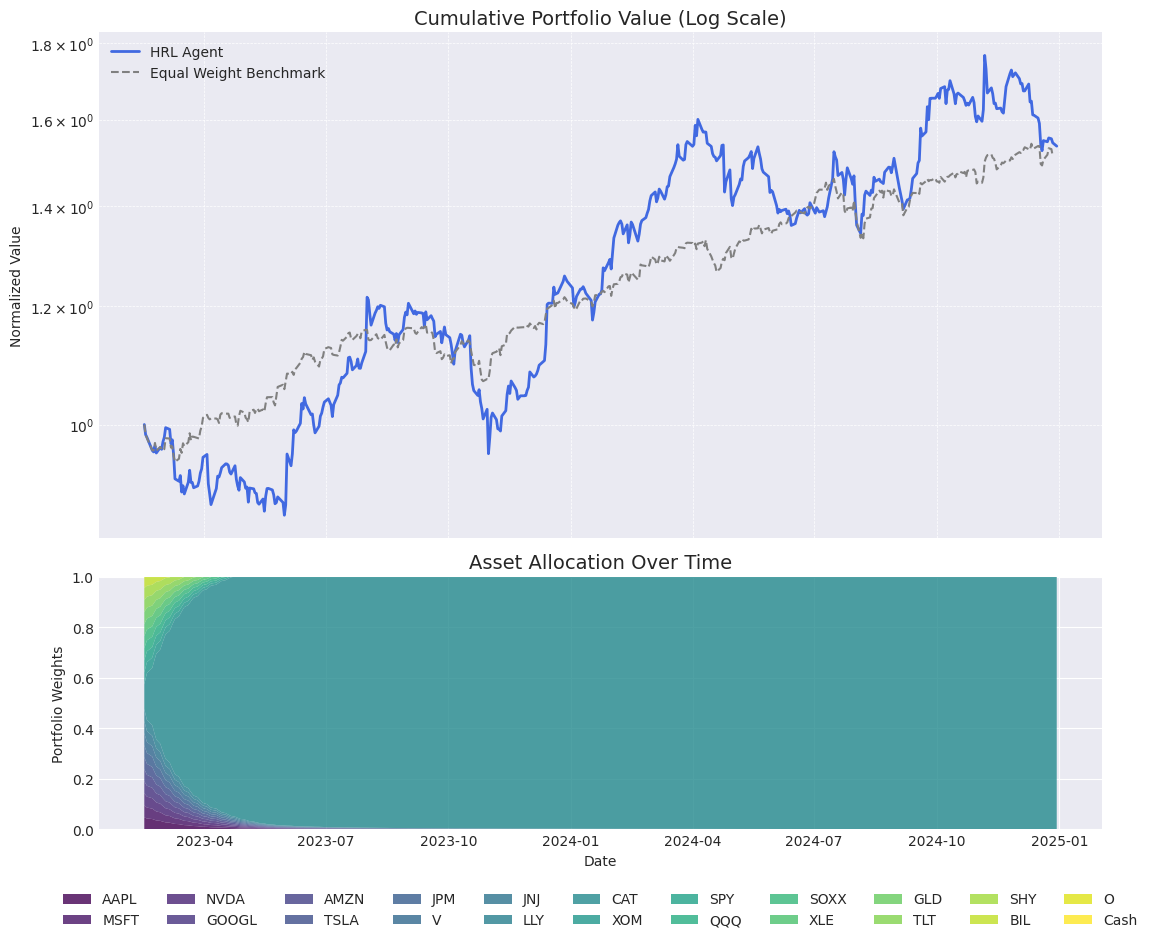

/workspaces/Deep-RL-for-Portfolio-Optimization/evaluation.py:141: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sells = df[df['Action'] % 2 == 0][df['Action'] != 0]


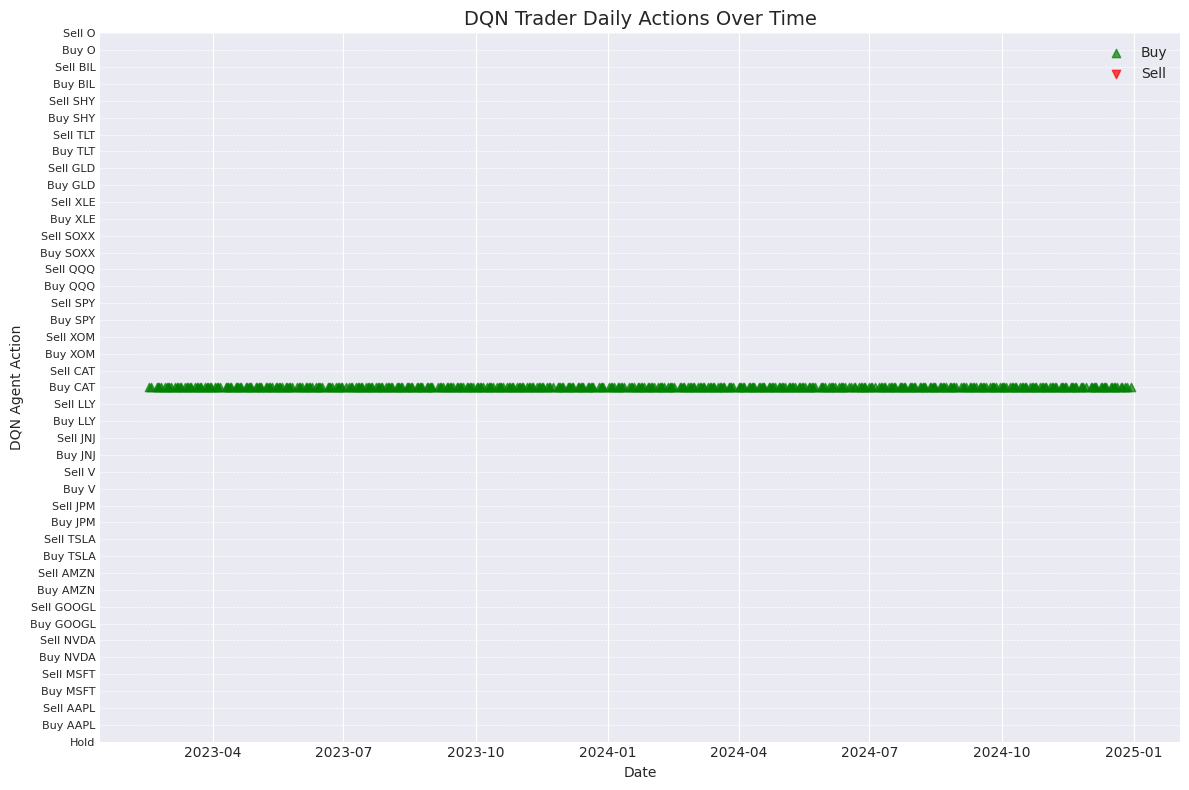


[5/5] ✅ 평가 및 시각화 완료.


In [4]:
# =================================================================================
# 5. 최종 평가 및 시각화
# =================================================================================
print("\n[4/4] 📊 최적 모델 로드 및 최종 평가 시작 (Out-of-Sample Backtest)...")

# --- 저장된 최적 PPO 및 DQN 모델 가중치 로드 ---
try:
    # 이전 단계에서 클래스 이름을 PPOAgent로 수정했으므로 ppo_agent를 사용합니다.
    ppo_agent.policy.load_state_dict(torch.load(os.path.join(MODEL_SAVE_PATH, 'best_ppo_model.pth')))
    dqn_agent.qnetwork_local.load_state_dict(torch.load(os.path.join(MODEL_SAVE_PATH, 'best_dqn_model.pth')))
    print("✅ 최적 모델 가중치를 성공적으로 로드했습니다.")
except FileNotFoundError:
    print("⚠️ 저장된 최적 모델을 찾을 수 없습니다. 마지막 시점의 모델로 평가합니다.")

# --- 테스트 데이터로 HRL 백테스트 실행 ---
# 테스트용 실행 환경 생성
exec_test_env = DailyExecutionEnv(test_df, TICKERS, INITIAL_PORTFOLIO_VALUE, TRANSACTION_COST_PCT, lookback_window=LOOKBACK_WINDOW)

# 결과 기록용 리스트 초기화
test_portfolio_values = [INITIAL_PORTFOLIO_VALUE]
test_portfolio_weights = [calculate_initial_weights(assets=TICKERS, method='equal')]
test_dqn_actions = [] 
test_start_step = 30
test_dates = [test_df.index[test_start_step - 1]]
temp_upper_env_test = MultiAssetPortfolioEnv(test_df, TICKERS, [])

# 주 단위로 백테스트 진행
for week in tqdm(range(len(test_df) // TRADING_DAYS_PER_WEEK), desc="Backtesting on Test Set"):
    if test_start_step + TRADING_DAYS_PER_WEEK > len(test_df): break
    
    temp_upper_env_test.weights = test_portfolio_weights[-1]
    temp_upper_env_test.current_step = test_start_step
    upper_state = temp_upper_env_test._get_state()
    target_weights = ppo_agent.act(upper_state)

    exec_test_env.set_target(test_portfolio_weights[-1], target_weights)
    exec_test_env.portfolio_value = test_portfolio_values[-1]

    for day in range(TRADING_DAYS_PER_WEEK):
        if test_start_step + day >= len(test_df): break
        lower_state = exec_test_env.reset(test_start_step + day)
        lower_action = dqn_agent.act(lower_state, eps=0.0)
        
        test_dqn_actions.append(lower_action)
        _, _, _, _ = exec_test_env.step(lower_action)
        test_portfolio_values.append(exec_test_env.portfolio_value)
        test_portfolio_weights.append(exec_test_env.weights)
        test_dates.append(test_df.index[test_start_step + day])
    
    test_start_step += TRADING_DAYS_PER_WEEK

# --- HRL 결과 데이터프레임 생성 ---
final_dates = test_dates[:len(test_portfolio_values)]
hrl_results_df = pd.DataFrame({
    'portfolio_value': test_portfolio_values,
    'weights': test_portfolio_weights
}, index=final_dates)
action_dates = test_dates[1:len(test_dqn_actions)+1] 

# --- 벤치마크(동일 비중) 실행 ---
print("\n--- Running Backtest for Equal Weight Benchmark ---")
# MultiAssetPortfolioEnv를 벤치마크용으로 재사용
benchmark_env = MultiAssetPortfolioEnv(test_df, TICKERS, calculate_initial_weights(assets=TICKERS, method='equal'), initial_portfolio_value=INITIAL_PORTFOLIO_VALUE)
benchmark_env.reset()
benchmark_values = [benchmark_env.initial_portfolio_value]
benchmark_dates = [benchmark_env.df.index[benchmark_env.current_step - 1]]
done = False
while not done:
    _, _, done, info = benchmark_env.step(benchmark_env.initial_weights)
    benchmark_values.append(info.get('portfolio_value'))
    benchmark_dates.append(benchmark_env.df.index[benchmark_env.current_step - 1])

final_benchmark_dates = benchmark_dates[:len(benchmark_values)]
benchmark_df = pd.DataFrame({'portfolio_value': benchmark_values}, index=final_benchmark_dates)

# --- 최종 성과 지표 출력 ---
hrl_metrics = calculate_performance_metrics(hrl_results_df['portfolio_value'])
benchmark_metrics = calculate_performance_metrics(benchmark_df['portfolio_value'])

print("\n" + "="*50)
print(" " * 15 + "PERFORMANCE SUMMARY")
print("="*50)
summary_df = pd.DataFrame({'HRL Agent': hrl_metrics, 'Benchmark': benchmark_metrics}).T
for col in ['CAGR', 'Annualized Volatility', 'Max Drawdown (MDD)']:
    summary_df[col] = summary_df[col].apply(lambda x: f"{x:.2%}")
summary_df['Sharpe Ratio'] = summary_df['Sharpe Ratio'].apply(lambda x: f"{x:.2f}")
print(summary_df)
print("="*50 + "\n")

# --- 시각화 ---
plot_evaluation_results(hrl_results_df, benchmark_df, TICKERS)
plot_dqn_actions(action_dates, test_dqn_actions, TICKERS)

print("\n[5/5] ✅ 평가 및 시각화 완료.")